# Sentiment analysis of IMDB movie reviews using LSTM Recurrent Neural Networks.

In this notebook, we are using LSTM recurrent neural networks to classify IMDB movie reviews positive or negative.
>

**Prerequisites:**
* **Basic knowledge of Deep Learning and Recurrent Neural Networks.**

**Libraries:**
* **Keras:** A library for creating neural networks in few lines.
* **Matplotlib:** Matplotlib is a plotting library. You can use it to draw different types of graphs, like line, scattered, bar, etc.
>


# Introduction

We are using a dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). Words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

# Preprocessing

In [0]:
from keras.models import Sequential
from keras.layers import CuDNNLSTM, Embedding, Dense
from keras.datasets import imdb
from keras.preprocessing import sequence

import matplotlib.pyplot as plt

In [0]:
max_word_range = 10000

(input_train, output_train), (input_test, output_test) = imdb.load_data(num_words=max_word_range)

print(len(input_train), 'train sequences.')
print(len(input_test), 'test sequences.')

25000 train sequences.
25000 test sequences.


In [0]:
max_word_amount = 500

input_train = sequence.pad_sequences(input_train, maxlen=max_word_amount)
input_test = sequence.pad_sequences(input_test, maxlen=max_word_amount)

print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

input_train shape: (25000, 500)
input_test shape: (25000, 500)


# Model

Now, let's create our model. We are initiating our sequential object with a list that contains the layers we want to use.

* **Embedding:** Turns positive integers (indexes) into dense vectors of fixed size. This layer can only be used as the first layer in a model.

* **CuDNNLSTM:** Fast LSTM implementation with CuDNN. Can only be run on GPU, with the TensorFlow backend.

* **Dense (Fully Connected):** They are the simple layers that have connections between every input and output neuron. 

We should use Sigmoid as our output activation function since there are two classes to choose from. Use Softmax in multi-class problems.

In [0]:
model = Sequential([
  Embedding(max_word_range, 32, input_length=max_word_amount),
  CuDNNLSTM(32),
  Dense(1, activation='sigmoid')
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 32)                8448      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 328,481
Trainable params: 328,481
Non-trainable params: 0
_________________________________________________________________


Now we have to decide which optimizer and loss function to use for our model. Since this is a binary classification problem and since we are using Sigmoid for the last activation function, Binary Crossentropy should be our choice. 

And for our optimizer, we can pick RMSProp. It works really well on recurrent neural networks.
>

**Loss Function:** Binary Crossentropy

For more information about Keras loss functions [click here](https://keras.io/losses/).
>

**Optimizer:** RMSProp

For more information about Keras optimizers [click here](https://keras.io/optimizers/).



In [0]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Training

Let's train our model. Additional to loss, accuracy will be calculated and  printed out on every epoch.

In [0]:
history = model.fit(input_train, output_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 10s 522us/step - loss: 0.5081 - acc: 0.7506 - val_loss: 0.3448 - val_acc: 0.8624
Epoch 2/10
20000/20000 [==============================] - 10s 477us/step - loss: 0.3101 - acc: 0.8754 - val_loss: 0.3024 - val_acc: 0.8742
Epoch 3/10
20000/20000 [==============================] - 10s 478us/step - loss: 0.2520 - acc: 0.9050 - val_loss: 0.2810 - val_acc: 0.8838
Epoch 4/10
20000/20000 [==============================] - 10s 477us/step - loss: 0.2129 - acc: 0.9196 - val_loss: 0.3027 - val_acc: 0.8786
Epoch 5/10
20000/20000 [==============================] - 10s 479us/step - loss: 0.1863 - acc: 0.9308 - val_loss: 0.2921 - val_acc: 0.8796
Epoch 6/10
20000/20000 [==============================] - 10s 478us/step - loss: 0.1690 - acc: 0.9410 - val_loss: 0.3083 - val_acc: 0.8840
Epoch 7/10
20000/20000 [==============================] - 10s 477us/step - loss: 0.1530 - acc: 0.9450 - val_loss: 0.5

We can see how training went using our history object.

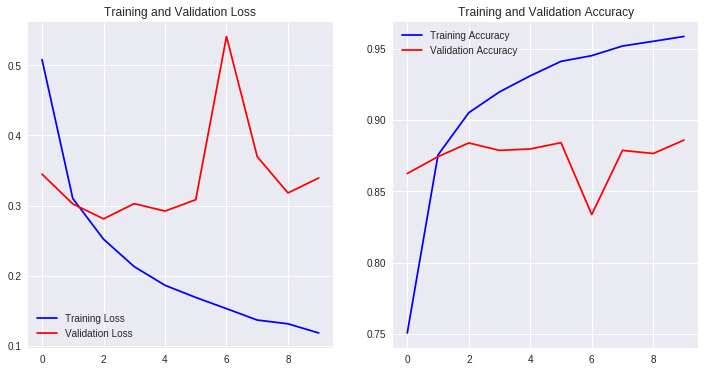

In [0]:
loss = history.history['loss']
acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
epochs = range(len(loss))

f, axarr = plt.subplots(1, 2, figsize=(12, 6))
p0 = axarr[0]
p1 = axarr[1]

p0.set_title("Training and Validation Loss")
p1.set_title("Training and Validation Accuracy")

p0l0 = p0.plot(epochs, loss, "-b", label="Training Loss")
p0l1 = p0.plot( epochs, val_loss, "-r", label="Validation Loss")

p1l0 = p1.plot(epochs, acc, "-b", label="Training Accuracy")
p1l1 = p1.plot(epochs, val_acc, "-r", label="Validation Accuracy")

legend0 = p0.legend()
legend1 = p1.legend()

# Evaluation

Finally the training process is done. Now we can evaluate our model's performance on the test set.

In [0]:
score = model.evaluate(input_test, output_test)

print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

25000/25000 [==============================] - 23s 926us/step
Test Loss: 0.38157773265838624
Test Accuracy: 0.8678


As you can see, our model's predictions are 86% accurate on the test set.

Let's predict couple of examples.
>

*Side note: You can't predict single examples with "model.predict()". But you can reshape the data to have an extra batch size dimention to fix it.*

In [0]:
predictions = model.predict(input_test[0:5])

true_labels = output_test[0:5]

print("0 is a negative comment, 1 is a positive comment.")

for i in range(len(predictions)):
  print("Prediction:", int(round(predictions[i][0])), ",",
        "True Label:", true_labels[i])

0 is a negative comment, 1 is a positive comment.
Prediction: 0 , True Label: 0
Prediction: 1 , True Label: 1
Prediction: 1 , True Label: 1
Prediction: 1 , True Label: 0
Prediction: 1 , True Label: 1
